# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree
import pandas as pd

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

import itertools
from sklearn.metrics import classification_report

from array import array
import numpy as np

Welcome to JupyROOT 6.18/00


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [3]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [4]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_1tag", "Xtohh1000")

outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

We have two kinds of signals and for the training we have to use only one of them.

In [5]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetSignalWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [6]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=70%:nTrain_Background=70%:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [7]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

In [8]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='sigmoid', input_dim=10))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________


2019-10-01 16:42:27.151399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2195135000 Hz
2019-10-01 16:42:27.152008: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8b20510 executing computations on platform Host. Devices:
2019-10-01 16:42:27.152028: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-10-01 16:42:27.195688: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


In [9]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=G:FilenameModel=model_dense.h5:'+\
        'NumEpochs=10:BatchSize=16:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0x89a63e0>

## Train, Test and Evaluate Model

In [10]:
factory.TrainAllMethods()

# Here we test all methods using the test data set
factory.TestAllMethods()

# Here we evaluate all methods and compare their performances, computing efficiencies, 
# ROC curves etc.. using both training and tetsing data sets. Several histograms are 
# produced which can be examined with the TMVAGui or directly using the output file
factory.EvaluateAllMethods()


Train on 112 samples, validate on 28 samples
Epoch 1/10
112/112 [==============================] - 0s 2ms/step - loss: 0.6880 - categorical_accuracy: 0.5089 - val_loss: 0.6264 - val_categorical_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.62642, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/10
112/112 [==============================] - 0s 166us/step - loss: 0.6611 - categorical_accuracy: 0.6786 - val_loss: 0.6032 - val_categorical_accuracy: 0.7143

Epoch 00002: val_loss improved from 0.62642 to 0.60316, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/10
112/112 [==============================] - 0s 166us/step - loss: 0.6358 - categorical_accuracy: 0.7500 - val_loss: 0.5779 - val_categorical_accuracy: 0.8571

Epoch 00003: val_loss improved from 0.60316 to 0.57790, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 4/10
112/112 [==============================] - 0s 130us/step - loss: 0.6188 - categorical_accuracy

## Plot ROC Curve
We enable JavaScript visualisation for the plots

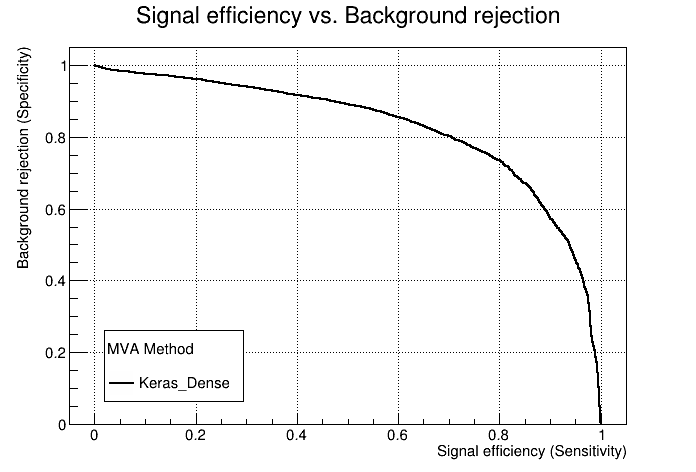

In [11]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## DNN Complete Function

In [51]:
def get_params(file):
    params = []
    first = 1
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            if (file.split('.')[1] == 'csv' and first):
                first = 0
                line = fp.readline().rstrip()
                continue
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [52]:
def DNN(params, training, model_input, comp_params, model_name, config):
    
    output_file = config+"_DNN_Classification.root"
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification_"+config, outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    #signalWeight     = 1.0
    #backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetSignalWeightExpression("EventWeight")
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    # Model structure
    
    comp_params = comp_params.rstrip()
    comp_params = comp_params.split(',')
    loss = comp_params[0]
    
    comp_params.remove(loss)
    metrics = comp_params
    
    model = Sequential()
    model_input = model_input.rstrip()
    model_input = model_input.split(',')
    
    hidden_l = int(model_input[0])
    neurons = int(model_input[1])
    neurons_LF = int(model_input[2])
    k_init = model_input[3]
    activation_IL = model_input[4]
    activation_HL = model_input[5]
    activation_FL = model_input[6]
    
    print(type(neurons))
    
    model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_IL, input_dim=10))
    for h in range(hidden_l):
        model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_HL))
        
    model.add(Dense(neurons_LF, kernel_initializer=k_init, activation=activation_FL))
    
    # Set loss and optimizer
    model.compile(loss=loss, optimizer=Adam(), metrics=metrics)
    # Store model to file
    model.save(model_name)
    # Print summary of model
    model.summary()
    
    ## DNN method
    factory.BookMethod(loader,ROOT.TMVA.Types.kPyKeras, "Keras_Dense", params)
        
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "Keras_Dense")
    
    print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [53]:
def write_combs_params(file_params, file_training, file_model, comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics):
    comb_params = list(itertools.product(arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics))
    with open(file_params, 'w') as params, open(file_training, 'w') as training, open(file_model, 'w') as model, open(comp_params, 'w') as comp_p:
        model.write("number_HL,neurons,neurons_LF,k_init,activation_IL,activation_HL,activation_FL\n")
        for cp in comb_params:
            string1 = "H:!V:VarTransform=N_AllClasses:FilenameModel="+model_name+":NumEpochs="+str(cp[0])+":BatchSize="+str(cp[1])+":TriesEarlyStopping=10\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[2])+"%:nTrain_Background="+str(cp[3])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)
            string3 = str(cp[4])+','+str(cp[5])+','+str(cp[6])+','+str(cp[7])+','+str(cp[8])+','+str(cp[9])+','+str(cp[10])+'\n'
            model.write(string3)
            string4 = str(cp[11])+','+str(cp[12])+'\n'
            comp_p.write(string4)

In [54]:
file_params="dnn_params2.txt"
file_training="dnn_training2.txt"
file_model="dnn_model2.csv"
file_comp_params='comp_params.txt'
model_name="model_dense.h5"
arr_NumEpochs=[10]
arr_BatchSize=[100, 200]
arr_nTrain_Signal=[80]
arr_nTrain_Background=[80]
arr_number_HL=[3]
arr_neurons=[64]
arr_neurons_LF=[2]
arr_k_init=['glorot_normal']
arr_activation_IL=['sigmoid']
arr_activation_HL=['relu']
arr_activation_FL=['softmax']
arr_loss=['categorical_crossentropy']
arr_metrics=['categorical_accuracy']

In [55]:
write_combs_params(file_params, file_training, file_model, file_comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics)

## Hyperparameter Optimization

In [56]:
def param_opt(config, params, training, model, comp_params, model_name):
    max_roc = 0
    best_params = ""
    best_train = ""
    best_model = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = DNN(params[i], training[i], model[i], comp_params[i], model_name, config)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
            best_model = model[i]
    best_model = best_model.split(',')
    best_model_str = "numero_HL="+str(best_model[0])+", neurons="+str(best_model[1])+", neurons_LF="+str(best_model[2])+", k_init="+str(best_model[3])+", activation_IL="+str(best_model[4])+", activation_HL="+str(best_model[5])+", activation_FL="+str(best_model[6])
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("best model:", best_model_str)
    print("ROC integral:", max_roc)
    return

In [57]:
params_path = "dnn_params2.txt"
params = get_params(params_path)
training_path = "dnn_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"
comp_params_path = "comp_params.txt"
comp_params = get_params(comp_params_path)
model_input_path = "dnn_model2.csv"
model_input = get_params(model_input_path)
model_name = "model_dense.h5"

In [58]:
DNN(params[0], training[0], model_input[0], comp_params[0], model_name, configs[7])

<class 'int'>
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________
Train on 128 samples, validate on 32 samples
Epoch 1/10
128/128 [==============================] - 0s 

0.7091585847900198

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       Keras_Dense    : 0.709
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

Warning in <TFile::Init>: file SR_1tag_Xtohh1000_s.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_s.root, recovered key TTree:Nominal at address 8294
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file SR_1tag_Xtohh1000_b.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_b.root, recovered key TTree:Nominal at address 480267
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0


In [24]:
param_opt(configs[2], params, training, model_input, comp_params, model_name)

PreSel_2tag_Xtohh1000
<class 'int'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________
Train on 160 samples, validate on 5178 samples
Epoch 1/10
160/160 [==============================] - 1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0


# Prediction

In [2]:
# Add weights
def v_out(tree, not_cons, variables, methodName, reader, hname):
    
    h = {}
    h[methodName] = (ROOT.TH1D(hname,"htitle_"+hname,60,-1,1))
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt, dtype='float').reshape(1, nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        vout[0,ievt] = reader.EvaluateMVA(methodName)
        h[methodName].Fill(vout[0,ievt])
    
    return h, vout, variables

In [3]:
def gen_report_pred(background, signal, data, sep):
    background = list(background[0])
    signal = list(signal[0])
    data = list(data[0])
    bakg_t = [0]*len(background)
    signal_t = [1]*len(signal)
    y_predicted = background + signal
    y_test = bakg_t + signal_t
    for i in range(len(y_predicted)):
        if (y_predicted[i] < sep):
            y_predicted[i] = 0
        else:
            y_predicted[i] = 1
    for j in range(len(data)):
        if (data[j] < sep):
            data[j] = 0
        else:
            data[j] = 1
    print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
    return data

In [6]:
def predict(config, type_signal, methodName, sep):
    reader = TMVA.Reader( "!Color:!Silent" )
    
    dataPath = config + "_" + type_signal + "_d.root"
    bkgPath = config + "_" + type_signal + "_b.root"
    sigPath = config + "_" + type_signal + "_s.root"
    
    print(dataPath)
    
    dataFile = ROOT.TFile(dataPath)
    bkgFile = ROOT.TFile(bkgPath)
    sigFile = ROOT.TFile(sigPath)

    dataTree = dataFile.Nominal
    bkgTree = bkgFile.Nominal
    sigTree = sigFile.Nominal
    
    # Add Variables: We add variables to the reader exactly in the same way we did for the **DataLoader** during the training
    # We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree
    variables = []
    i = 0
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
    
    for branch in dataTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    # Setup Classifiers: We set up the classifiers by reading the input weights from the appropriate files
    # The file is stored for example as *dataset/weights/TMVAClassification_BDT.weights.xml
    weightfile = "dataset/weights/TMVA_Higgs_Classification_" + config + "_" + type_signal + "_" + methodName + ".weights.xml"
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    # We iterate on the input event in the given TTree. We provide as input first the background tree 
    # We return the output results for the various methods in big numpy array [ number of methods x 
    # number of events]
    # We also fill an histogram for each method.
    # Note that is important to fill the arrays with the tree entries in order to pass the values to 
    # the TMVA::Reader
    hd, d_vout, variables = v_out(dataTree, not_cons, variables, methodName, reader, "data")
    hs, s_vout, variables = v_out(sigTree, not_cons, variables, methodName, reader, "signal")
    hb, b_vout, variables = v_out(bkgTree, not_cons, variables, methodName, reader, "bkg")
    
    # Classification report
    prediction = gen_report_pred(b_vout, s_vout, d_vout, sep)
    
    # Histogram
    '''c1 = ROOT.TCanvas()
    pad = c1.cd(0)
    h1 = hb[methodName]
    h1.Draw()
    h2 = hs[methodName]
    h2.SetLineColor(ROOT.kRed)
    h3 = hd[methodName]
    h3.SetFillColor(ROOT.kGreen)
    h1.SetFillColor(ROOT.kBlue)
    h2.Draw('Same')
    h3.Draw('Same')
    pad.BuildLegend()
    c1.Modified()
    c1.Update()

    c1.Draw()
    c1.Print()'''
    
    dataFile.Close()
    sigFile.Close()
    bkgFile.Close()
    
    return prediction

In [12]:
config = "SR_1tag"
type_signal = "Xtohh1000"
methodName = "Keras_Dense"
sep = 0.5
asd = predict(config, type_signal, methodName, sep)

SR_1tag_Xtohh1000_d.root
              precision    recall  f1-score   support

  background       0.86      0.15      0.26      9262
      signal       0.30      0.94      0.45      3553

    accuracy                           0.37     12815
   macro avg       0.58      0.54      0.35     12815
weighted avg       0.71      0.37      0.31     12815

                         : Booking "Keras_Dense" of type "PyKeras" from dataset/weights/TMVA_Higgs_Classification_SR_1tag_Xtohh1000_Keras_Dense.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Higgs_Classification_SR_1tag_Xtohh1000_Keras_Dense.weights.xml
<WARNING> <WARNING>                : Value for option tensorboard was previously set to 
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "Keras_Dense" of type: "PyKeras"
                         : Load model from file: d

Warning in <TFile::Init>: file SR_1tag_Xtohh1000_d.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_d.root, recovered key TTree:Nominal at address 244
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file SR_1tag_Xtohh1000_b.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_b.root, recovered key TTree:Nominal at address 480267
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file SR_1tag_Xtohh1000_s.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_s.root, recovered key TTree:Nominal at address 8294
Warning in <TFile::Init>: successfully recovered 1 keys
